In [28]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load cleaned data
df = pd.read_csv("D:/F ML Lab/Project/ML/processed/PROJECT_CLEANED_DATA.csv")


In [29]:
df.columns

Index(['primaryid', 'age', 'drug_count', 'indication_count', 'reaction_count',
       'all_reaction_pts', 'is_failure', 'rept_cod_5DAY', 'rept_cod_DIR',
       'rept_cod_EXP', 'rept_cod_PER', 'sex_I', 'sex_M', 'sex_P', 'sex_T',
       'sex_UNK', 'occp_cod_HP', 'occp_cod_LW', 'occp_cod_MD', 'occp_cod_OT',
       'occp_cod_PH', 'occp_cod_UNK', 'reporter_country_COUNTRY NOT SPECIFIED',
       'reporter_country_GB', 'reporter_country_OTHER', 'reporter_country_US'],
      dtype='object')

In [ ]:
from sklearn.metrics import silhouette_score
# Filter to failure reports only
failure_df = df[df['is_failure'] == 1]

# TF-IDF vectorization on reaction terms
tfidf = TfidfVectorizer(stop_words='english', max_features=2000)
X_react = tfidf.fit_transform(failure_df['all_reaction_pts'].astype(str))


# Dimensionality Reduction
svd = TruncatedSVD(n_components=50, random_state=42)
X_react_reduced = svd.fit_transform(X_react)

# Clustering: KMeans
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
phenotype_labels = kmeans.fit_predict(X_react_reduced)

failure_df['Failure_Phenotype'] = phenotype_labels

score = silhouette_score(X_react_reduced, phenotype_labels)
print(f"Silhouette Score for KMeans clustering: {score:.4f}")

# Examine clusters for dominant terms
for i in range(n_clusters):
    cluster_indices = np.where(phenotype_labels == i)[0]
    print(f"\nPhenotype {i} sample reactions:")
    print(failure_df.iloc[cluster_indices]['all_reaction_pts'].head())


C:\Users\RAM PRAHASITH\AppData\Local\Temp\ipykernel_3628\3346545126.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failure_df['Failure_Phenotype'] = phenotype_labels


Silhouette Score for KMeans clustering: 0.3434

Phenotype 0 sample reactions:
26          COMPLETED SUICIDE TOXICITY TO VARIOUS AGENTS
279         COMPLETED SUICIDE TOXICITY TO VARIOUS AGENTS
328    ACUTE KIDNEY INJURY COAGULOPATHY COMA DEPRESSE...
338      COMA TOXICITY TO VARIOUS AGENTS TREMOR VOMITING
353                           TOXICITY TO VARIOUS AGENTS
Name: all_reaction_pts, dtype: object

Phenotype 1 sample reactions:
3                                       HOSPITALISATION
4                                           SPONDYLITIS
6     BLOOD PRESSURE DECREASED DEPRESSED LEVEL OF CO...
12    BRONCHOPLEURAL FISTULA PNEUMOTHORAX CONDITION ...
13                       MALIGNANT NEOPLASM PROGRESSION
Name: all_reaction_pts, dtype: object

Phenotype 2 sample reactions:
80     DEATH
107    DEATH
115    DEATH
178    DEATH
191    DEATH
Name: all_reaction_pts, dtype: object

Phenotype 3 sample reactions:
103    DRUG INEFFECTIVE
110    DRUG INEFFECTIVE
122    DRUG INEFFECTIVE
124    DRUG I

In [43]:
failure_df.loc[:, 'failure_Phenotype'] = phenotype_labels

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = []
K_range = range(3, 9)  # Try 3 to 8 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_react_reduced)
    score = silhouette_score(X_react_reduced, labels)
    scores.append(score)
    print(f"K = {k}, Silhouette Score = {score:.4f}")

best_k = K_range[scores.index(max(scores))]
print(f"Best K based on silhouette score: {best_k}")


K = 3, Silhouette Score = 0.2769
K = 4, Silhouette Score = 0.3434
K = 5, Silhouette Score = 0.2999
K = 6, Silhouette Score = 0.2864
K = 7, Silhouette Score = 0.2312
K = 8, Silhouette Score = 0.2395
Best K based on silhouette score: 4


Visualisation

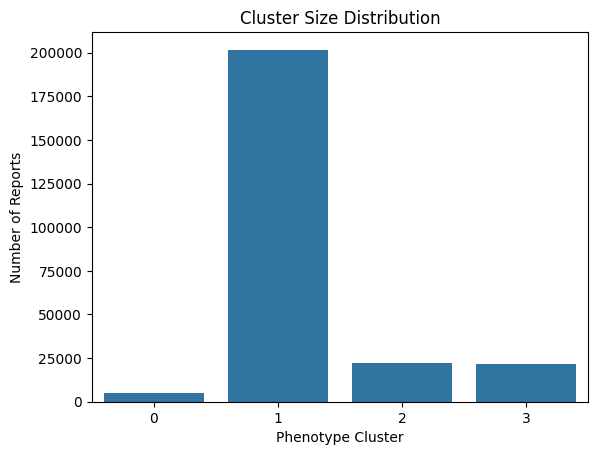

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=phenotype_labels)
plt.title("Cluster Size Distribution")
plt.xlabel("Phenotype Cluster")
plt.ylabel("Number of Reports")
plt.show()


In [2]:
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns

# Run UMAP on your reduced TF-IDF matrix
mapper = UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(X_react_reduced)

# Plot the results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=mapper[:, 0], y=mapper[:, 1], hue=phenotype_labels, palette='bright', legend='full', alpha=0.7)
plt.title("2D UMAP Projection of Therapeutic Failure Phenotype Clusters")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title='Phenotype Cluster')
plt.show()


NameError: name 'X_react_reduced' is not defined

1. Merge Phenotype Labels to Full Data

In [47]:
if 'failure_Phenotype' in df.columns:
    df = df.drop(columns=['failure_Phenotype'])
# Assign cluster labels to failure subset
failure_df.loc[:, 'failure_Phenotype'] = phenotype_labels

# Merge phenotype labels back to full cleaned dataset
df = df.merge(
    failure_df[['primaryid', 'failure_Phenotype']],
    on='primaryid', how='left'
)

# Fill missing phenotype labels for non-failure reports with -1
df['failure_Phenotype'] = df['failure_Phenotype'].fillna(-1).astype(int)

print("Phenotype column added. Examples:")
print(df[['primaryid', 'failure_Phenotype']].head())


Phenotype column added. Examples:
   primaryid  failure_Phenotype
0  127337111                 -1
1  175404651                 -1
2  216513911                 -1
3  166753522                  1
4  150010251                  1


Snippet 2: Prepare Data For Supervised Learning

In [48]:
# Filter rows with valid phenotype labels for supervised classification
clf_df = df[df['failure_Phenotype'].notnull() & (df['failure_Phenotype'] != -1)].copy()

# Drop any remaining NaNs in phenotype
clf_df = clf_df.dropna(subset=['failure_Phenotype'])

# Define feature columns (excluding reaction text)
feature_cols = (
    ['age', 'drug_count', 'indication_count', 'reaction_count'] +
    [col for col in df.columns if col.startswith('sex_')] +
    [col for col in df.columns if col.startswith('occp_cod_')] +
    [col for col in df.columns if col.startswith('reporter_country_')]
)

X = clf_df[feature_cols]
y = clf_df['failure_Phenotype'].astype(int)

from sklearn.model_selection import train_test_split

# Stratified train-test split for balanced classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Data split: Train size = {X_train.shape[0]}, Test size = {X_test.shape[0]}")


Data split: Train size = 200193, Test size = 50049


Snippet 3: Train and Evaluate Models

In [49]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Train Multinomial Naive Bayes
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)
print("Multinomial Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_mnb))

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Train XGBoost
xgb = XGBClassifier(
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))


Multinomial Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.04      0.12      0.07       961
           1       0.92      0.62      0.74     40344
           2       0.23      0.41      0.29      4411
           3       0.24      0.66      0.35      4333

    accuracy                           0.60     50049
   macro avg       0.36      0.46      0.36     50049
weighted avg       0.78      0.60      0.66     50049

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.18      0.25       961
           1       0.88      0.93      0.90     40344
           2       0.47      0.32      0.38      4411
           3       0.48      0.45      0.46      4333

    accuracy                           0.82     50049
   macro avg       0.56      0.47      0.50     50049
weighted avg       0.80      0.82      0.81     50049



c:\Users\RAM PRAHASITH\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:02:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.12      0.21       961
           1       0.87      0.96      0.91     40344
           2       0.55      0.27      0.37      4411
           3       0.53      0.41      0.46      4333

    accuracy                           0.83     50049
   macro avg       0.68      0.44      0.49     50049
weighted avg       0.81      0.83      0.81     50049

